# Hybrid Gradient Boosting Trees  Example via Unified Classification

A data set that identifies whether or not a pentient has diabetes is used to demonstrate the use of hybrid graident boosting classifier in SAP HANA.



# Pima Indians Diabetes Dataset

Original data comes from National Institute of Diabetes and Digestive and Kidney Diseases. The collected dataset is aiming at, based on certain diagnostic measurements, diagnostically predicting whether or not a patient has diabetes. In particular, patients contained in the dataset are females of Pima Indian heritage, all above the age of 20. Dataset is form Kaggle, for tutorials use only.

The dataset contains the following diagnositic <b>attributes</b>:<br>
$\rhd$ "PREGNANCIES" - Number of times pregnant,<br>
$\rhd$ "GLUCOSE" - Plasma glucose concentration a 2 hours in an oral glucose tolerance test,<br>
$\rhd$ "BLOODPRESSURE" -  Diastolic blood pressure (mm Hg),<br>
$\rhd$ "SKINTHICKNESS" -  Triceps skin fold thickness (mm),<br>
$\rhd$ "INSULIN" - 2-Hour serum insulin (mu U/ml),<br>
$\rhd$ "BMI" - Body mass index $(\text{weight in kg})/(\text{height in m})^2$,<br>
$\rhd$ "PEDIGREE" - Diabetes pedigree function,<br>
$\rhd$ "AGE" -  Age (years),<br>
$\rhd$ "CLASS" - Class variable (0 or 1) 268 of 768 are 1(diabetes), the others are 0(non-diabetes).



In [1]:
import hana_ml
from hana_ml import dataframe
from hana_ml.algorithms.pal import metrics
from hana_ml.algorithms.pal.unified_classification import UnifiedClassification

# Load Data

The data is loaded into 3 tables - full set, training-validation set, and test set as follows:

<li> PIMA_INDIANS_DIABETES_TBL</li>
<li> PIMA_INDIANS_DIABETES_TRAIN_VALID_TBL</li>
<li> PIMA_INDIANS_DIABETES_TEST_TBL</li>

To do that, a connection is created and passed to the loader.

There is a config file, <b>config/e2edata.ini</b> that controls the connection parameters and whether or not to reload the data from scratch. In case the data is already loaded, there would be no need to load the data. A sample section is below. If the config parameter, reload_data is true then the tables for test, training and validation are (re-)created and data inserted into them.

#########################<br>
[hana]<br>
url=host.sjc.sap.corp<br>
user=username<br>
passwd=userpassword<br>
port=3xx15<br>
#########################<br>

In [2]:
from data_load_utils import DataSets, Settings
import plotting_utils
url, port, user, pwd = Settings.load_config("../../config/e2edata.ini")
connection_context = dataframe.ConnectionContext(url, port, user, pwd)
full_tbl, train_tbl, test_tbl, _ = DataSets.load_diabetes_data(connection_context)

Table PIMA_INDIANS_DIABETES_TBL exists and data exists


In [3]:
from hana_ml.algorithms.pal.utility import Settings

Settings.set_log_level()

# Create Data Frames

Create the data frames for the full, test, training, and validation sets.

Let us also do some data exploration.

# Define Datasets - training set and testing set

Data frames are used keep references to data so computation on large data sets in HANA can happen in HANA. Trying to bring the entire data set into the client will likely result in out of memory exceptions.

In [4]:
diabetes_train = connection_context.table(train_tbl)
#diabetes_train = diabetes_train.cast('CLASS', 'VARCHAR(10)')
diabetes_test = connection_context.table(test_tbl)
#diabetes_test = diabetes_test.cast('CLASS', 'VARCHAR(10)')

# Simple Exploration

Let us look at the number of rows in each dataset:

In [5]:
print('Number of rows in training set: {}'.format(diabetes_train.count()))
print('Number of rows in testing set: {}'.format(diabetes_test.count()))

Number of rows in training set: 614
Number of rows in testing set: 76


Let us look at columns of the dataset:

In [6]:
print(diabetes_train.columns)

['ID', 'PREGNANCIES', 'GLUCOSE', 'BLOODPRESSURE', 'SKINTHICKNESS', 'INSULIN', 'BMI', 'PEDIGREE', 'AGE', 'CLASS']


Let us also look some (in this example, the top 6) rows of the dataset:

In [7]:
diabetes_train.head(6).collect()

,ID,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,PEDIGREE,AGE,CLASS
0,1,6,102,90,39,0,35.7,0.674,28,0
1,2,11,127,106,0,0,39.0,0.190,51,0
2,3,13,145,82,19,110,22.2,0.245,57,0
3,4,4,123,62,0,0,32.0,0.226,35,1
4,5,7,100,0,0,0,30.0,0.484,32,1
5,6,4,154,62,31,284,32.8,0.237,23,0


We can also check the data type of all columns:

In [8]:
diabetes_train.dtypes()

[('ID', 'INT', 10, 10, 10, 0),
 ('PREGNANCIES', 'INT', 10, 10, 10, 0),
 ('GLUCOSE', 'INT', 10, 10, 10, 0),
 ('BLOODPRESSURE', 'INT', 10, 10, 10, 0),
 ('SKINTHICKNESS', 'INT', 10, 10, 10, 0),
 ('INSULIN', 'INT', 10, 10, 10, 0),
 ('BMI', 'DOUBLE', 15, 15, 15, 0),
 ('PEDIGREE', 'DOUBLE', 15, 15, 15, 0),
 ('AGE', 'INT', 10, 10, 10, 0),
 ('CLASS', 'INT', 10, 10, 10, 0)]

We have a 'CLASS' column in the dataset, let us check how many classes are contained in this dataset:

In [9]:
diabetes_train.distinct('CLASS').collect()

,CLASS
0,0
1,1


Two classes are available, assuring that this is a binary classification problem.

#  Model Creation & Model Selection
The lines below show the ease with which classification can be done.

Set up the label column, use default feature set and create the model:

In [10]:
cv_values = {}
cv_values['learning_rate'] = [0.1, 0.4, 0.7, 1.0]
cv_values['n_estimators'] = [4, 6, 8, 10]
cv_values['split_threshold'] = [0.1, 0.4, 0.7, 1.0]
hgc = UnifiedClassification(func='HybridGradientBoostingTree',
                            param_search_strategy='grid',
                            resampling_method='cv',
                            evaluation_metric='error_rate',
                            ref_metric=['auc'],
                            fold_num=5,
                            random_state=1,
                            param_values=cv_values)
hgc.fit(diabetes_train, key='ID', label='CLASS',
        partition_method='stratified',
        partition_random_state=1,
        stratified_column='CLASS')

INFO:hana_ml.ml_base:Executing SQL: DO
BEGIN
DECLARE param_name VARCHAR(5000) ARRAY;
DECLARE int_value INTEGER ARRAY;
DECLARE double_value DOUBLE ARRAY;
DECLARE string_value VARCHAR(5000) ARRAY;
param_name[1] := N'FUNCTION';
int_value[1] := NULL;
double_value[1] := NULL;
string_value[1] := N'HGBT';
param_name[2] := N'KEY';
int_value[2] := 1;
double_value[2] := NULL;
string_value[2] := NULL;
param_name[3] := N'PARTITION_METHOD';
int_value[3] := 2;
double_value[3] := NULL;
string_value[3] := NULL;
param_name[4] := N'PARTITION_RANDOM_SEED';
int_value[4] := 1;
double_value[4] := NULL;
string_value[4] := NULL;
param_name[5] := N'PARTITION_STRATIFIED_VARIABLE';
int_value[5] := NULL;
double_value[5] := NULL;
string_value[5] := N'CLASS';
param_name[6] := N'PARAM_SEARCH_STRATEGY';
int_value[6] := NULL;
double_value[6] := NULL;
string_value[6] := N'grid';
param_name[7] := N'RESAMPLING_METHOD';
int_value[7] := NULL;
double_value[7] := NULL;
string_value[7] := N'cv';
param_name[8] := N'EVALUATION_

In [11]:
from hana_ml.model_storage import ModelStorage
#from hana_ml.model_storage_services import ModelSavingServices


# Creates an object called model_storage which must use the same connection with the model
model_storage = ModelStorage(connection_context=connection_context)
model_storage.clean_up()
# Saves the model for the first time
hgc.name = 'Model A'  # The model name is mandatory
hgc.version = 1
model_storage.save_model(model=hgc)

# Lists models
model_storage.list_models()

INFO:hana_ml.ml_base:Executing SQL: SELECT 1 FROM "PAL_TEST"."HANAML_MODEL_STORAGE" LIMIT 1
INFO:hana_ml.ml_base:Executing SQL: SELECT 1 FROM "PAL_TEST"."HANAML_MODEL_STORAGE" LIMIT 1
INFO:hana_ml.ml_base:Executing SQL: SET TRANSACTION AUTOCOMMIT DDL OFF
INFO:hana_ml.ml_base:Executing SQL: SELECT 1 FROM "PAL_TEST"."HANAML_MODEL_STORAGE" LIMIT 1
INFO:hana_ml.ml_base:Executing SQL: CREATE COLUMN TABLE "PAL_TEST"."HANAML_MODEL_STORAGE" (NAME VARCHAR(255) NOT NULL, VERSION INT NOT NULL, LIBRARY VARCHAR(128) NOT NULL, CLASS VARCHAR(255) NOT NULL, JSON VARCHAR(5000) NOT NULL, TIMESTAMP TIMESTAMP NOT NULL, STORAGE_TYPE VARCHAR(255) NOT NULL, MODEL_STORAGE_VER INT NOT NULL, SCHEDULE VARCHAR(5000), PRIMARY KEY(NAME, VERSION) )
INFO:hana_ml.ml_base:Executing SQL: CREATE COLUMN TABLE "PAL_TEST"."HANAML_MODEL_A_1_CLASS_HANA_ML_ALGORITHMS_PAL_UNIFIED_CLASSIFICATION_UNIFIEDCLASSIFICATION_MODELS_0" AS (SELECT * FROM "#PAL_UNIFIED_CLASSIFICATION_MODEL_0_4AB0ECAC_DED8_11EB_94E4_E4A7A0658DBB")
INFO:hana

,NAME,VERSION,LIBRARY,CLASS,JSON,TIMESTAMP,STORAGE_TYPE,MODEL_STORAGE_VER,SCHEDULE
0,Model A,1,PAL,hana_ml.algorithms.pal.unified_classification....,"{""model_attributes"": {""func"": ""HybridGradientB...",2021-07-07 12:03:54,default,1,"{""schedule"": {""status"": ""inactive"", ""schedule_..."


In [12]:
# plan the schedule

model_storage.set_schedule(name='Model A',
                           version=1,
                           schedule_time='every 3 minutes',
                           connection_userkey='raymondyao',
                           init_params={"func" : 'HybridGradientBoostingTree',
                                        "param_search_strategy" : 'grid',
                                        "resampling_method" : 'cv',
                                        "evaluation_metric" : 'error_rate',
                                        "ref_metric" : ['auc'],
                                        "fold_num" : 5,
                                        "random_state" : 1,
                                        "param_values" : {'learning_rate': [0.1, 0.4, 0.7, 1],
                                                          'n_estimators': [4, 6, 8, 10],
                                                          'split_threshold': [0.1, 0.4, 0.7, 1]}},
                           fit_params={"key" : 'ID',
                                       "label" : 'CLASS',
                                       "partition_method" : 'stratified',
                                       "partition_random_state" : 1,
                                       "stratified_column" : 'CLASS'},
                           training_dataset_select_statement="SELECT * FROM DIABETES_TRAIN"
                          )

INFO:hana_ml.ml_base:Executing SQL: SELECT 1 FROM "PAL_TEST"."HANAML_MODEL_STORAGE" LIMIT 1
INFO:hana_ml.ml_base:Executing SQL: UPDATE "PAL_TEST"."HANAML_MODEL_STORAGE" set SCHEDULE = '{"schedule": {"status": "inactive", "schedule_time": "every 3 minutes", "pid": null, "client": null, "connection": {"userkey": "raymondyao", "encrypt": "false", "sslValidateCertificate": "true"}, "hana_ml_obj": "hana_ml.algorithms.pal.unified_classification.UnifiedClassification", "init_params": {"func": "HybridGradientBoostingTree", "param_search_strategy": "grid", "resampling_method": "cv", "evaluation_metric": "error_rate", "ref_metric": ["auc"], "fold_num": 5, "random_state": 1, "param_values": {"learning_rate": [0.1, 0.4, 0.7, 1], "n_estimators": [4, 6, 8, 10], "split_threshold": [0.1, 0.4, 0.7, 1]}}, "fit_params": {"key": "ID", "label": "CLASS", "partition_method": "stratified", "partition_random_state": 1, "stratified_column": "CLASS"}, "training_dataset_select_statement": "SELECT * FROM DIABETES_

In [13]:
model_storage.start_schedule('Model A', 1)

INFO:hana_ml.ml_base:Executing SQL: SELECT 1 FROM "PAL_TEST"."HANAML_MODEL_STORAGE" LIMIT 1
INFO:SCHEDULE:Started the schedule process 21508 by client PVGN50944362A
INFO:hana_ml.ml_base:Executing SQL: UPDATE "PAL_TEST"."HANAML_MODEL_STORAGE" set SCHEDULE = '{"schedule": {"status": "active", "schedule_time": "every 3 minutes", "pid": 21508, "client": "PVGN50944362A", "connection": {"userkey": "raymondyao", "encrypt": "false", "sslValidateCertificate": "true"}, "hana_ml_obj": "hana_ml.algorithms.pal.unified_classification.UnifiedClassification", "init_params": {"func": "HybridGradientBoostingTree", "param_search_strategy": "grid", "resampling_method": "cv", "evaluation_metric": "error_rate", "ref_metric": ["auc"], "fold_num": 5, "random_state": 1, "param_values": {"learning_rate": [0.1, 0.4, 0.7, 1], "n_estimators": [4, 6, 8, 10], "split_threshold": [0.1, 0.4, 0.7, 1]}}, "fit_params": {"key": "ID", "label": "CLASS", "partition_method": "stratified", "partition_random_state": 1, "stratifi

In [14]:
model_storage.list_models().iat[0, 7]

INFO:hana_ml.ml_base:Executing SQL: SELECT 1 FROM "PAL_TEST"."HANAML_MODEL_STORAGE" LIMIT 1


1

In [15]:
model_storage.terminate_schedule('Model A', 1)

INFO:hana_ml.ml_base:Executing SQL: SELECT 1 FROM "PAL_TEST"."HANAML_MODEL_STORAGE" LIMIT 1
INFO:SCHEDULE:Terminating schedule and killing process 21508 started by client PVGN50944362A.
INFO:hana_ml.ml_base:Executing SQL: UPDATE "PAL_TEST"."HANAML_MODEL_STORAGE" set SCHEDULE = '{"schedule": {"status": "inactive", "schedule_time": "every 3 minutes", "pid": null, "client": null, "connection": {"userkey": "raymondyao", "encrypt": "false", "sslValidateCertificate": "true"}, "hana_ml_obj": "hana_ml.algorithms.pal.unified_classification.UnifiedClassification", "init_params": {"func": "HybridGradientBoostingTree", "param_search_strategy": "grid", "resampling_method": "cv", "evaluation_metric": "error_rate", "ref_metric": ["auc"], "fold_num": 5, "random_state": 1, "param_values": {"learning_rate": [0.1, 0.4, 0.7, 1], "n_estimators": [4, 6, 8, 10], "split_threshold": [0.1, 0.4, 0.7, 1]}}, "fit_params": {"key": "ID", "label": "CLASS", "partition_method": "stratified", "partition_random_state": 1

In [16]:
model_storage.list_models().iat[0, 7]

INFO:hana_ml.ml_base:Executing SQL: SELECT 1 FROM "PAL_TEST"."HANAML_MODEL_STORAGE" LIMIT 1


1

In [17]:
from hana_ml.algorithms.pal.model_selection import GridSearchCV
from hana_ml.algorithms.pal.model_selection import RandomSearchCV
hgc2 = UnifiedClassification('HybridGradientBoostingTree')

gscv = GridSearchCV(estimator=hgc2, 
                    param_grid={'learning_rate': [0.1, 0.4, 0.7, 1],
                                'n_estimators': [4, 6, 8, 10],
                                'split_threshold': [0.1, 0.4, 0.7, 1]},
                    train_control=dict(fold_num=5,
                                       resampling_method='cv',
                                       random_state=1,
                                       ref_metric=['auc']),
                    scoring='error_rate')
gscv.fit(data=diabetes_train, key= 'ID',
         label='CLASS',
         partition_method='stratified',
         partition_random_state=1,
         stratified_column='CLASS',
         build_report=True)

INFO:hana_ml.ml_base:Executing SQL: DO
BEGIN
DECLARE param_name VARCHAR(5000) ARRAY;
DECLARE int_value INTEGER ARRAY;
DECLARE double_value DOUBLE ARRAY;
DECLARE string_value VARCHAR(5000) ARRAY;
param_name[1] := N'FUNCTION';
int_value[1] := NULL;
double_value[1] := NULL;
string_value[1] := N'HGBT';
param_name[2] := N'KEY';
int_value[2] := 1;
double_value[2] := NULL;
string_value[2] := NULL;
param_name[3] := N'PARTITION_METHOD';
int_value[3] := 2;
double_value[3] := NULL;
string_value[3] := NULL;
param_name[4] := N'PARTITION_RANDOM_SEED';
int_value[4] := 1;
double_value[4] := NULL;
string_value[4] := NULL;
param_name[5] := N'PARTITION_STRATIFIED_VARIABLE';
int_value[5] := NULL;
double_value[5] := NULL;
string_value[5] := N'CLASS';
param_name[6] := N'PARAM_SEARCH_STRATEGY';
int_value[6] := NULL;
double_value[6] := NULL;
string_value[6] := N'grid';
param_name[7] := N'EVALUATION_METRIC';
int_value[7] := NULL;
double_value[7] := NULL;
string_value[7] := N'ERROR_RATE';
param_name[8] := N'LEA

# Evaluation

Let us compare cross-validation accuracy and test accuracy:

In [18]:
cm = hgc.confusion_matrix_.collect()
cm

,ACTUAL_CLASS,PREDICTED_CLASS,COUNT
0,0,0,62
1,0,1,17
2,1,0,15
3,1,1,29


In [19]:
gscv.estimator.confusion_matrix_.collect()

,ACTUAL_CLASS,PREDICTED_CLASS,COUNT
0,0,0,62
1,0,1,17
2,1,0,15
3,1,1,29


In [20]:
train_accuracy = float(cm['COUNT'][cm['ACTUAL_CLASS']==cm['PREDICTED_CLASS']].sum())/cm['COUNT'].sum()
train_accuracy

0.7398373983739838

In [21]:
features = diabetes_train.columns
features.remove('CLASS')
features.remove('ID')
print(features)

['PREGNANCIES', 'GLUCOSE', 'BLOODPRESSURE', 'SKINTHICKNESS', 'INSULIN', 'BMI', 'PEDIGREE', 'AGE']


In [22]:
pred_res = hgc.predict(diabetes_test, key='ID', features=features)
pred_res.head(10).collect()
pred_res.dtypes()

INFO:hana_ml.ml_base:Executing SQL: DO (IN in_1 TABLE ("ROW_INDEX" INT, "PART_INDEX" INT, "MODEL_CONTENT" NCLOB) => "#PAL_UNIFIED_CLASSIFICATION_MODEL_0_4AB0ECAC_DED8_11EB_94E4_E4A7A0658DBB")
BEGIN
DECLARE param_name VARCHAR(5000) ARRAY;
DECLARE int_value INTEGER ARRAY;
DECLARE double_value DOUBLE ARRAY;
DECLARE string_value VARCHAR(5000) ARRAY;
param_name[1] := N'FUNCTION';
int_value[1] := NULL;
double_value[1] := NULL;
string_value[1] := N'HGBT';
params = UNNEST(:param_name, :int_value, :double_value, :string_value);
in_0 = SELECT "ID", "PREGNANCIES", "GLUCOSE", "BLOODPRESSURE", "SKINTHICKNESS", "INSULIN", "BMI", "PEDIGREE", "AGE" FROM (SELECT * FROM "PIMA_INDIANS_DIABETES_TEST_TBL") AS "DT_5";
CALL _SYS_AFL.PAL_UNIFIED_CLASSIFICATION_PREDICT(:in_0, :in_1, :params, out_0, out_1);
CREATE LOCAL TEMPORARY COLUMN TABLE "#PAL_UNIFIED_CLASSIF_PREDICT_RESULT_TBL_0_703A0379_DED8_11EB_A793_E4A7A0658DBB" AS (SELECT * FROM :out_0);
CREATE LOCAL TEMPORARY COLUMN TABLE "#PAL_UNIFIED_CLASSIF_PREDI

[('ID', 'INT', 10, 10, 10, 0),
 ('SCORE', 'NVARCHAR', 256, 256, 256, 0),
 ('CONFIDENCE', 'DOUBLE', 15, 15, 15, 0),
 ('REASON_CODE', 'NCLOB', 2147483647, 2147483647, 2147483647, 0)]

In [23]:
ts = diabetes_test.rename_columns({'ID': 'TID'}) .cast('CLASS', 'NVARCHAR(256)')
jsql = '{}."{}"={}."{}"'.format(pred_res.quoted_name, 'ID', ts.quoted_name, 'TID')
results_df = pred_res.join(ts, jsql, how='inner')
cm_df, classification_report_df = metrics.confusion_matrix(results_df, key='ID', label_true='CLASS', label_pred='SCORE') 

INFO:hana_ml.ml_base:Executing SQL: DO
BEGIN
DECLARE param_name VARCHAR(5000) ARRAY;
DECLARE int_value INTEGER ARRAY;
DECLARE double_value DOUBLE ARRAY;
DECLARE string_value VARCHAR(5000) ARRAY;
params = UNNEST(:param_name, :int_value, :double_value, :string_value);
in_0 = SELECT "ID", "CLASS", "SCORE" FROM (SELECT * FROM (SELECT * FROM "#PAL_UNIFIED_CLASSIF_PREDICT_RESULT_TBL_0_703A0379_DED8_11EB_A793_E4A7A0658DBB") AS "DT_87" INNER JOIN (SELECT "TID", "PREGNANCIES", "GLUCOSE", "BLOODPRESSURE", "SKINTHICKNESS", "INSULIN", "BMI", "PEDIGREE", "AGE", CAST("CLASS" AS NVARCHAR(256)) AS "CLASS" FROM (SELECT "ID" AS "TID", "PREGNANCIES", "GLUCOSE", "BLOODPRESSURE", "SKINTHICKNESS", "INSULIN", "BMI", "PEDIGREE", "AGE", "CLASS" FROM (SELECT * FROM "PIMA_INDIANS_DIABETES_TEST_TBL") AS "DT_5") AS "DT_90") AS "DT_91" ON "DT_87"."ID"="DT_91"."TID") AS "DT_92";
CALL _SYS_AFL.PAL_CONFUSION_MATRIX(:in_0, :params, out_0, out_1);
CREATE LOCAL TEMPORARY COLUMN TABLE "#CM_MATRIX_TBL_7496BE5C_DED8_11EB_90

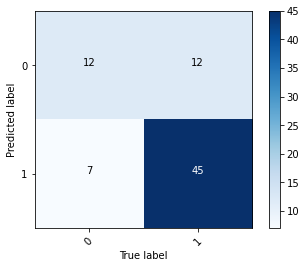

In [24]:
import matplotlib.pyplot as plt
from hana_ml.visualizers.metrics import MetricsVisualizer
f, ax1 = plt.subplots(1,1)
mv1 = MetricsVisualizer(ax1)
ax1 = mv1.plot_confusion_matrix(cm_df, normalize=False)

In [25]:
print("Recall, Precision and F_measures.")
classification_report_df.collect()

Recall, Precision and F_measures.


,CLASS,RECALL,PRECISION,F_MEASURE,SUPPORT
0,0,0.865385,0.789474,0.825688,52
1,1,0.500000,0.631579,0.558140,24


In [26]:
_,_,_,metrics_res = hgc.score(data=diabetes_test, key='ID', label='CLASS')
metrics_res.collect()

INFO:hana_ml.ml_base:Executing SQL: DO (IN in_1 TABLE ("ROW_INDEX" INT, "PART_INDEX" INT, "MODEL_CONTENT" NCLOB) => "#PAL_UNIFIED_CLASSIFICATION_MODEL_0_4AB0ECAC_DED8_11EB_94E4_E4A7A0658DBB")
BEGIN
DECLARE param_name VARCHAR(5000) ARRAY;
DECLARE int_value INTEGER ARRAY;
DECLARE double_value DOUBLE ARRAY;
DECLARE string_value VARCHAR(5000) ARRAY;
param_name[1] := N'FUNCTION';
int_value[1] := NULL;
double_value[1] := NULL;
string_value[1] := N'HGBT';
params = UNNEST(:param_name, :int_value, :double_value, :string_value);
in_0 = SELECT "ID", "PREGNANCIES", "GLUCOSE", "BLOODPRESSURE", "SKINTHICKNESS", "INSULIN", "BMI", "PEDIGREE", "AGE", "CLASS" FROM (SELECT * FROM "PIMA_INDIANS_DIABETES_TEST_TBL") AS "DT_5";
CALL _SYS_AFL.PAL_UNIFIED_CLASSIFICATION_SCORE(:in_0, :in_1, :params, out_0, out_1, out_2, out_3);
CREATE LOCAL TEMPORARY COLUMN TABLE "#PAL_UNIFIED_CLASSIFICATION_SCORE_RESULT_TBL_0_7BFA8504_DED8_11EB_9EF4_E4A7A0658DBB" AS (SELECT * FROM :out_0);
CREATE LOCAL TEMPORARY COLUMN TABLE "

,NAME,X,Y
0,RANDOM_CUMGAINS,0.000000,0.000000
1,RANDOM_CUMGAINS,1.000000,1.000000
2,RANDOM_LIFT,0.000000,1.000000
3,RANDOM_LIFT,1.000000,1.000000
4,RANDOM_CUMLIFT,0.000000,1.000000
...,...,...,...
321,CUMLIFT,0.789474,1.183333
322,CUMLIFT,0.842105,1.156250
323,CUMLIFT,0.894737,1.088235
324,CUMLIFT,0.947368,1.055556


In [27]:
from hana_ml.model_storage import ModelStorage

model_storage = ModelStorage(connection_context=connection_context)
gscv.estimator.name = 'HGBT' 
gscv.estimator.version = 1
model_storage.save_model(model=gscv.estimator)
# Lists models
model_storage.list_models()

INFO:hana_ml.ml_base:Executing SQL: SELECT 1 FROM "PAL_TEST"."HANAML_MODEL_STORAGE" LIMIT 1
INFO:hana_ml.ml_base:Executing SQL: SET TRANSACTION AUTOCOMMIT DDL OFF
INFO:hana_ml.ml_base:Executing SQL: SELECT 1 FROM "PAL_TEST"."HANAML_MODEL_STORAGE" LIMIT 1
INFO:hana_ml.ml_base:Executing SQL: CREATE COLUMN TABLE "PAL_TEST"."HANAML_HGBT_1_CLASS_HANA_ML_ALGORITHMS_PAL_UNIFIED_CLASSIFICATION_UNIFIEDCLASSIFICATION_MODELS_0" AS (SELECT * FROM "#PAL_UNIFIED_CLASSIFICATION_MODEL_2_5C80EE82_DED8_11EB_BB09_E4A7A0658DBB")
INFO:hana_ml.ml_base:Executing SQL: CREATE COLUMN TABLE "PAL_TEST"."HANAML_HGBT_1_CLASS_HANA_ML_ALGORITHMS_PAL_UNIFIED_CLASSIFICATION_UNIFIEDCLASSIFICATION_MODELS_1" AS (SELECT * FROM "#PAL_UNIFIED_CLASSIFICATION_STATS_2_5C80EE82_DED8_11EB_BB09_E4A7A0658DBB")
INFO:hana_ml.ml_base:Executing SQL: CREATE COLUMN TABLE "PAL_TEST"."HANAML_HGBT_1_CLASS_HANA_ML_ALGORITHMS_PAL_UNIFIED_CLASSIFICATION_UNIFIEDCLASSIFICATION_MODELS_2" AS (SELECT * FROM "#PAL_UNIFIED_CLASSIFICATION_OPT_PARAM_2_

,NAME,VERSION,LIBRARY,CLASS,JSON,TIMESTAMP,STORAGE_TYPE,MODEL_STORAGE_VER,SCHEDULE
0,Model A,2,PAL,hana_ml.algorithms.pal.trees.HybridGradientBoo...,"{""model_attributes"": {""n_estimators"": null, ""r...",2021-07-07 12:03:59,default,1,"{""schedule"": {""status"": ""inactive"", ""schedule_..."
1,Model A,1,PAL,hana_ml.algorithms.pal.unified_classification....,"{""model_attributes"": {""func"": ""HybridGradientB...",2021-07-07 12:03:54,default,1,"{""schedule"": {""status"": ""inactive"", ""schedule_..."
2,HGBT,1,PAL,hana_ml.algorithms.pal.unified_classification....,"{""model_attributes"": {""func"": ""hybridgradientb...",2021-07-07 12:05:12,default,1,"{""schedule"": {""status"": ""inactive"", ""schedule_..."


In [28]:
from hana_ml.visualizers.unified_report import UnifiedReport

mymodel = model_storage.load_model('HGBT', 1)
mymodel.fit(data=diabetes_train, key= 'ID',
            label='CLASS',
            partition_method='stratified',
            partition_random_state=1,
            stratified_column='CLASS',
            build_report=True)
UnifiedReport(mymodel).display()

INFO:hana_ml.ml_base:Executing SQL: SELECT 1 FROM "PAL_TEST"."HANAML_MODEL_STORAGE" LIMIT 1
INFO:hana_ml.ml_base:Executing SQL: SELECT 1 FROM "PAL_TEST"."HANAML_MODEL_STORAGE" LIMIT 1
INFO:hana_ml.ml_base:Executing SQL: DO
BEGIN
DECLARE param_name VARCHAR(5000) ARRAY;
DECLARE int_value INTEGER ARRAY;
DECLARE double_value DOUBLE ARRAY;
DECLARE string_value VARCHAR(5000) ARRAY;
param_name[1] := N'FUNCTION';
int_value[1] := NULL;
double_value[1] := NULL;
string_value[1] := N'HGBT';
param_name[2] := N'KEY';
int_value[2] := 1;
double_value[2] := NULL;
string_value[2] := NULL;
param_name[3] := N'PARTITION_METHOD';
int_value[3] := 2;
double_value[3] := NULL;
string_value[3] := NULL;
param_name[4] := N'PARTITION_RANDOM_SEED';
int_value[4] := 1;
double_value[4] := NULL;
string_value[4] := NULL;
param_name[5] := N'PARTITION_STRATIFIED_VARIABLE';
int_value[5] := NULL;
double_value[5] := NULL;
string_value[5] := N'CLASS';
param_name[6] := N'PARAM_SEARCH_STRATEGY';
int_value[6] := NULL;
double_valu

In order to review the unified classification model report better, you need to adjust the size of the left area or hide the left area temporarily!


In [29]:
model_storage.delete_model('HGBT', 1)
connection_context.close()

INFO:hana_ml.ml_base:Executing SQL: SELECT 1 FROM "PAL_TEST"."HANAML_MODEL_STORAGE" LIMIT 1
INFO:hana_ml.ml_base:Executing SQL: SELECT 1 FROM "PAL_TEST"."HANAML_MODEL_STORAGE" LIMIT 1
INFO:hana_ml.ml_base:Executing SQL: SELECT 1 FROM "PAL_TEST"."HANAML_MODEL_STORAGE" LIMIT 1
INFO:hana_ml.ml_base:Executing SQL: SELECT 1 FROM "PAL_TEST"."HANAML_MODEL_STORAGE" LIMIT 1
INFO:hana_ml.ml_base:Executing SQL: DROP TABLE "PAL_TEST"."HANAML_HGBT_1_CLASS_HANA_ML_ALGORITHMS_PAL_UNIFIED_CLASSIFICATION_UNIFIEDCLASSIFICATION_MODELS_0"
INFO:hana_ml.ml_base:Executing SQL: DROP TABLE "PAL_TEST"."HANAML_HGBT_1_CLASS_HANA_ML_ALGORITHMS_PAL_UNIFIED_CLASSIFICATION_UNIFIEDCLASSIFICATION_MODELS_1"
INFO:hana_ml.ml_base:Executing SQL: DROP TABLE "PAL_TEST"."HANAML_HGBT_1_CLASS_HANA_ML_ALGORITHMS_PAL_UNIFIED_CLASSIFICATION_UNIFIEDCLASSIFICATION_MODELS_2"
INFO:hana_ml.ml_base:Executing SQL: DROP TABLE "PAL_TEST"."HANAML_HGBT_1_CLASS_HANA_ML_ALGORITHMS_PAL_UNIFIED_CLASSIFICATION_UNIFIEDCLASSIFICATION_MODELS_3"
INFO